# Parameter Estimation: Approximate Bayesian Computation

Approximate Bayesian Computation (ABC) methods involve sampling candidate parameters from prior distributions $\theta^* \sim \pi(\theta)$, using a mathematical or computational model to obtain simulated data, $D^*$, and comparing the simulated data with observed data by means of a distance functions $d(D, D^*)$. Candidate parameters that yield a distance below a specified threshold, $\varepsilon$, form the approximate posterior sample.

We demonstrate how this method can be used to infer parameters of a simple SIR model.

In [1]:
import numpy as np

from scipy.integrate import odeint

from pygom import common_models, SquareLoss

from pygom import approximate_bayesian_computation as abc

import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 4]

We begin by loading the SIR model and generating synthetic data for the number of infected individuals.

In [2]:
paramEval = [('beta',0.005), ('gamma',0.2)]
ode = common_models.SIR(paramEval)

t = np.linspace(0, 70, 36)
x0 = [80, 1, 19]

sol = odeint(ode.ode, x0, t)
noisy_sol = sol[:,1] + np.random.normal(0, 5e-1, size=len(t))
noisy_sol[noisy_sol < 0] = 0

The `Parameter` class is used to specify the parameters we wish to infer. For each parameter, a prior distribution must be provided. Although we can choose from any of the distributions included in Pygom, here we use a uniform distribution to represent our initial uncertainty. Note that since $\beta$ is small, it is preferable to infer $\log_{10}\beta$. This is done by setting `logscale=True`.

In [3]:
parameters = [abc.Parameter('beta', 'unif', -5, -1, logscale=True),
             abc.Parameter('gamma', 'unif', 0, 1, logscale=False)]

To perform the inference, we begin as we would for the other estimation methods. Specifying `SquareLoss` is equivalent to using a Euclidean distance to compare model simulations with our synthetic data.

In [4]:
objSIR = abc.create_loss(SquareLoss, parameters, ode, x0, t[0], t[1:], noisy_sol[1:], ['I'])
abcSIR = abc.ABC(objSIR, parameters)

We can now sample $N=250$ parameter pairs from our approximate posterior distribution, initially choosing a relatively large tolerance.

Acceptance rate: 2.94%


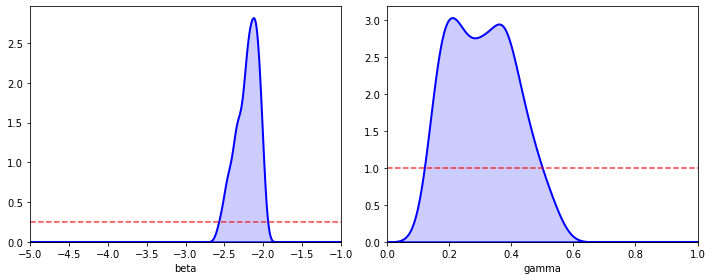

In [5]:
abcSIR.get_posterior_sample(N=250, tol=1000)

abcSIR.plot_posterior_histograms()
print(f'Acceptance rate: {abcSIR.acceptance_rate[0]:.2f}%')

The approximate posterior densities (blue) indicate that we have improved on our prior beliefs (red dashed line), however, there is still considerable variability, particularly in $\gamma$. Choosing a lower tolerance would help with this, although the already small acceptance rate would also decrease.

The inefficiency of the standard ABC method is its greatest limitation. For this reason, a sequential Monte Carlo method (ABC-SMC) has also been implemented. This approach instead considers a series of generations, with each generation using a smaller threshold than the previous. The first generation is equivalent to the standard ABC algorithm, in the sense that parameters are sampled from prior distributions. In subsequent generations, candidate parameters are proposed by perturbing weighted samples from the previous generation. Here, we use a multivariate normal distribution with optimal local covariance matrix to perform the perturbation.

The ABC-SMC method requires a couple of additional arguments to `get_posterior_sample`:
- G - the number of generations
- q - a quantile (0 < q < 1). Whilst it is possible to specify a list of tolerances to use in each generation, it is difficult to know what these should be. When specifying q, the tolerance for the current generation is set to the q-th quantile of the distances from the previous generation. Larger values of q will result in smaller reductions in thresholds but a higher acceptance rate.
    

In [6]:
abcSIR.get_posterior_sample(N=250, tol=np.inf, G=4, q=0.25, progress=True)

Generation 1 
 tolerance = inf 
 acceptance rate = 100.00%

Generation 2 
 tolerance = 1481.44241 
 acceptance rate = 20.31%

Generation 3 
 tolerance = 1237.83891 
 acceptance rate = 10.19%

Generation 4 
 tolerance = 718.69580 
 acceptance rate = 27.93%



If we want to run the method for a few more generations, there is no need to start from the beginning. Instead, we can use `continue_posterior_sample` along with the `next_tol` attribute to set the tolerance.

In [7]:
abcSIR.continue_posterior_sample(N=250, tol=abcSIR.next_tol, G=2, q=0.25, progress=True)

Generation 1 
 tolerance = 198.39410 
 acceptance rate = 36.18%

Generation 2 
 tolerance = 40.60977 
 acceptance rate = 32.98%



Posterior median estimates: beta=0.005, gamma=0.20


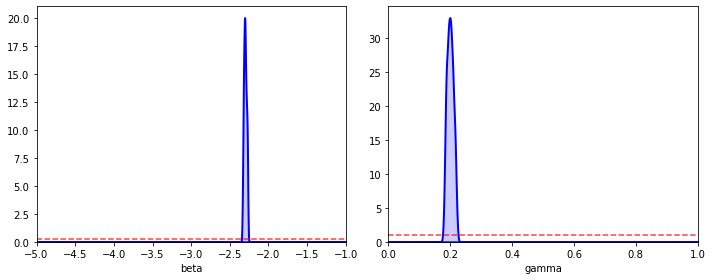

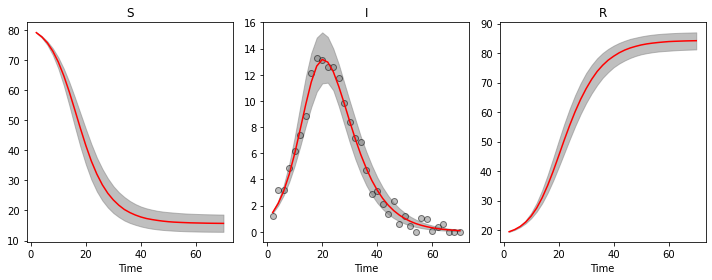

In [8]:
abcSIR.plot_posterior_histograms()

abcSIR.plot_pointwise_predictions()

print(f'Posterior median estimates: beta={10**np.median(abcSIR.res[:,0]):.3f}, gamma={np.median(abcSIR.res[:,1]):.2f}')

The ABC-SMC method is therefore a far more efficient approach to recover the true values for each parameter. The approximate posterior densities are now much narrower than before and the pointwise median predictions agree well with the data that we generated. The posterior sample is stored in `abcSIR.res` should it need to be saved.

In addition to inferring model parameters, the ABC methods can be used to estimate initial conditions. To do this, the state that we want to estimate the initial condition for should be included in the `parameters` list e.g. to infer $S(0)$ as well as $\beta$ and $\gamma$:

`parameters = [abc.Parameter('beta', 'unif', -5, -1, logscale=True),
              abc.Parameter('gamma', 'unif', 0, 1, logscale=False),
              abc.Parameter('S', 'unif', 0, 100, logscale=False)]`
              
The remaining code remains the same as before.